In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np
import xlsxwriter
import re
import datetime

In [2]:
import sys
sys.path.append(f'../../src/python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, get_feature_importance, get_feature_importance10, eval_matrix

Hbar -wc

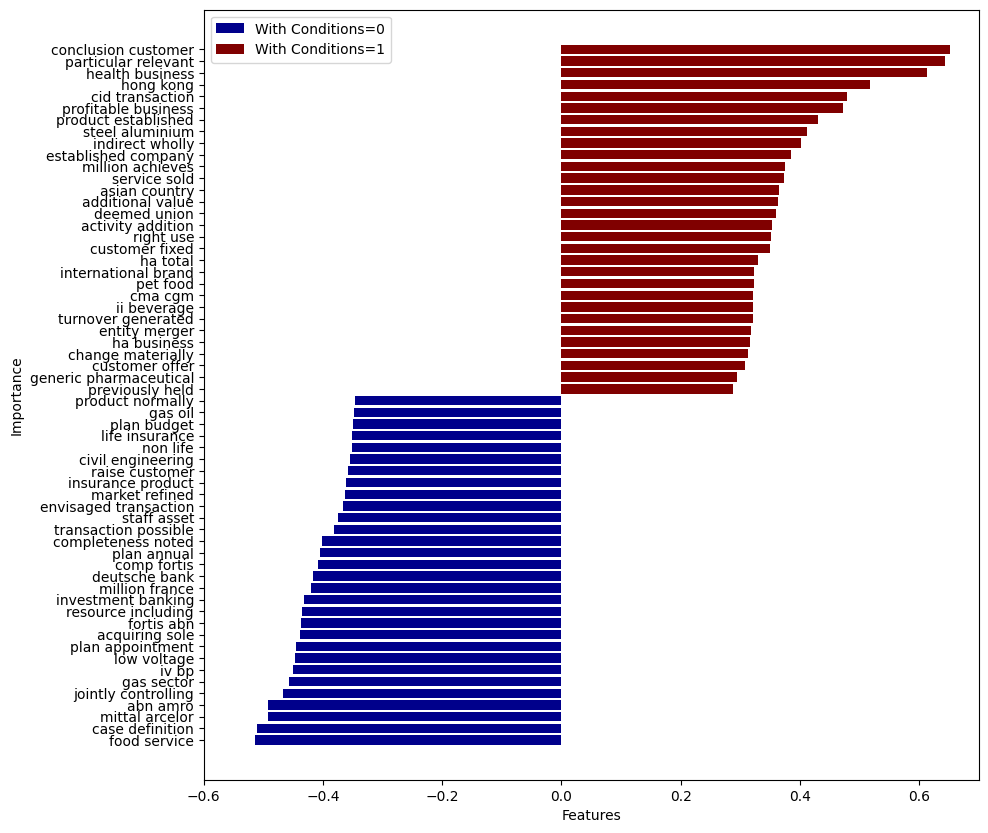

In [4]:
df_features_train_0 = pd.read_excel('../../output/tables/features_svm_wc.xlsx', sheet_name="Sheet_0")
   
df_features_train1_0, df_features_train0_0 = get_feature_importance10(df_features_train_0)

df_features_train1_0 = df_features_train1_0.sort_values(by='abs_importance', ascending=False)
df_features_train1_0_top = df_features_train1_0.nlargest(30, 'abs_importance')
df_features_train1_0_top = df_features_train1_0_top.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0_0 = df_features_train0_0.sort_values(by='abs_importance', ascending=False)
df_features_train0_0_top = df_features_train0_0.nlargest(30, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(df_features_train0_0_top['feature'], df_features_train0_0_top['importance'], color='darkblue', label='With Conditions=0')
ax.barh(df_features_train1_0_top['feature'], df_features_train1_0_top['importance'], color='maroon', label='With Conditions=1')


ax.set_ylabel('Importance')
ax.set_xlabel('Features')
# ax.set_title('Top 30 Features by Importance for With Conditions =0 and =1')
ax.legend()

# Set x-axis limits
ax.set_xlim(-0.6, 0.7)
plt.xticks(rotation=0)

# plt.show()

plt.savefig('../../output/figures/svm_wc_0_hor' + '.png', bbox_inches='tight')

Confusion matrix, tn, fn, tp, fp by nace_code

In [6]:
preds_svm_wc = pd.read_excel('../../output/preds/preds_svm_wc.xlsx', sheet_name="preds_train_0")

In [7]:
merger_info = pd.read_json(r"../../data/processed/merger_info_2023_03_25.json")

In [8]:
merger_info.columns

Index(['case_code', 'title', 'regulation_id', 'notification_date',
       'simpl_proc', 'last_decision_date', 'deadline_date', 'nace_code',
       'article'],
      dtype='object')

In [9]:
preds_svm_wc= pd.merge(preds_svm_wc, merger_info[['notification_date','case_code', 'article']], how='left', left_on=['case_code', 'article'], right_on=['case_code', 'article'])

In [11]:
preds_svm_wc['date'] = preds_svm_wc['notification_date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000.0))


In [12]:
preds_svm_wc['year'] = preds_svm_wc['date'].dt.year


In [13]:
preds_svm_wc.head(3)

,Unnamed: 0,case_num,article,text,target,y_predict,case_code,nace_code,cm,notification_date,date,year
0,0,M.3465,article6(2),The transaction will result in both horizontal...,1,1,M.3465,Manufacture of pesticides and other agrochemic...,tp,1088726400000,2004-07-02 02:00:00,2004
1,1,M.3496,article6(1)(b),A Relevant market The notifying party submits ...,0,0,M.3496,Service activities incidental to land transpor...,tn,1088467200000,2004-06-29 02:00:00,2004
2,2,M.3535,article6(1)(b),A Overview Both Van Drie and Schils are active...,0,0,M.3535,Manufacture of dairy products,tn,1099440000000,2004-11-03 01:00:00,2004


In [14]:
tn=preds_svm_wc[(preds_svm_wc.target == 0) & (preds_svm_wc.y_predict == 0)]
fp=preds_svm_wc[(preds_svm_wc.target == 0) & (preds_svm_wc.y_predict == 1)]
fn=preds_svm_wc[(preds_svm_wc.target == 1) & (preds_svm_wc.y_predict == 0)]
tp=preds_svm_wc[(preds_svm_wc.target == 1) & (preds_svm_wc.y_predict == 1)]


In [20]:
tn['nace_code'].value_counts().head(10)

Manufacture of basic iron and steel and of ferro-alloys                                                               3
Manufacture of refined petroleum products                                                                             3
Insurance, reinsurance and pension funding, except compulsory social security                                         3
Wholesale of solid, liquid and gaseous fuels and related products                                                     3
Manufacture of other electronic and electric wires and cables                                                         2
Telecommunications                                                                                                    2
Processing and preserving of meat and production of meat products                                                     2
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms    2
Service activities incidental to air tra

In [21]:
fn['nace_code'].value_counts().head(10)

Sea and coastal freight water transport                                                                                                                                            1
Activities auxiliary to financial services and insurance activities; Activities auxiliary to insurance and pension funding                                                         1
Manufacture of motor vehicles; Rental and leasing of cars and light motor vehicles; Service activities incidental to land transportation; Support activities for transportation    1
Other retail sale not in stores, stalls or markets                                                                                                                                 1
Manufacture of electrical and electronic equipment for motor vehicles; Manufacture of other parts and accessories for motor vehicles                                               1
Freight transport by road and removal services; Sea and coastal freight water transport; Servic

In [17]:
fp['nace_code'].value_counts().head(10)

Telecommunications                                                                                                4
Manufacture of other parts and accessories for motor vehicles                                                     4
Restaurants and mobile food service activities                                                                    3
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                      3
Financial service activities, except insurance and pension funding                                                2
Cargo handling; Sea and coastal freight water transport; Service activities incidental to water transportation    2
Manufacture of other chemical products                                                                            2
Support activities for petroleum and natural gas extraction                                                       2
Telecommunications; Wired telecommunications activities                 

In [16]:
tp['nace_code'].value_counts().head(10)

Manufacture of basic pharmaceutical products and pharmaceutical preparations       12
Manufacture of medical and dental instruments and supplies                          8
Manufacture of chemicals and chemical products                                      8
Telecommunications                                                                  6
Manufacture of air and spacecraft and related machinery                             3
Manufacture of food products                                                        3
Manufacture of pesticides and other agrochemical products                           2
Television programming and broadcasting activities                                  2
Manufacture of lifting and handling equipment                                       2
Manufacture of instruments and appliances for measuring, testing and navigation     2
Name: nace_code, dtype: int64

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pandas as pd


In [46]:
def get_bigrams(df,range,n):
    # Fit the TF-IDF vectorizer to the nace_code column in fp
    tfidf = TfidfVectorizer(ngram_range=range, stop_words='english')
    X = tfidf.fit_transform(df['nace_code'])

    # Get the feature names and scores of each document
    feature_names = tfidf.get_feature_names_out()
    scores = X.toarray()

    # Get the top ranking features
    sums = X.sum(axis=0)
    data1 = []
    for col, term in enumerate(feature_names):
        data1.append((term, sums[0, col]))
    ranking = pd.DataFrame(data1, columns=['term', 'rank'])
    words = ranking.sort_values('rank', ascending=False)

    print(words.head(n))

In [66]:
get_bigrams(tn,(2,2),20)

                       term      rank
200          motor vehicles  4.027656
155       manufacture basic  3.462207
290      service activities  3.360836
218         pension funding  2.577828
37        chemical products  2.391988
116           gaseous fuels  2.331836
24               basic iron  2.225563
86             ferro alloys  2.225563
137              iron steel  2.225563
301             steel ferro  2.225563
271             retail sale  2.213495
164  manufacture electronic  2.091512
298      specialised stores  2.000857
215       parts accessories  1.835915
158   manufacture chemicals  1.737722
38       chemicals chemical  1.737722
262       refined petroleum  1.732051
222      petroleum products  1.732051
183     manufacture refined  1.732051
108      funding compulsory  1.729877


In [68]:
get_bigrams(fn,(2,2),20)

                            term      rank
130       production electricity  1.272108
110               motor vehicles  1.200305
143                  retail sale  1.185596
3           activities auxiliary  1.077574
62           hospital activities  1.000000
159            sports activities  1.000000
180             waste collection  1.000000
119              pension funding  0.992461
70             insurance pension  0.992461
121  pharmaceutical preparations  0.895756
95    manufacture pharmaceutical  0.895756
84             manufacture basic  0.869003
152           service activities  0.819060
14           auxiliary insurance  0.799488
52                 freight water  0.753446
25               coastal freight  0.753446
151                  sea coastal  0.753446
181              water transport  0.753446
46          fertilisers nitrogen  0.743301
111           nitrogen compounds  0.743301


In [62]:
get_bigrams(fp,(2,2),20)

                              term      rank
320  telecommunications activities  4.460486
299             service activities  3.325146
49               chemical products  3.027463
216                 motor vehicles  2.933200
188              manufacture parts  2.373835
0                accessories motor  2.373835
230              parts accessories  2.373835
32                 basic chemicals  2.324567
164           manufacture chemical  1.992782
161              manufacture basic  1.904685
62            computer programming  1.766921
71             consultancy related  1.766921
268        programming consultancy  1.766921
279             related activities  1.766921
44         broadcasting activities  1.653019
267       programming broadcasting  1.653019
258           products manufacture  1.603290
110                   food service  1.591918
213                    mobile food  1.591918
285             restaurants mobile  1.591918


In [67]:
get_bigrams(tp,(2,2),20)

                              term      rank
233              manufacture basic  7.264424
353    pharmaceutical preparations  6.888008
354        pharmaceutical products  6.608082
57            basic pharmaceutical  6.608082
394        products pharmaceutical  6.000959
73               chemical products  5.824822
238          manufacture chemicals  5.630511
74              chemicals chemical  5.630511
34                   air transport  4.770939
116             dental instruments  4.282019
210           instruments supplies  4.282019
300                 medical dental  4.282019
267            manufacture medical  4.282019
449             service activities  3.733315
479  telecommunications activities  3.604935
67         broadcasting activities  3.453602
401       programming broadcasting  3.453602
338                  passenger air  3.092576
332               paper paperboard  2.873403
483         television programming  2.736103
